In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [2]:
# implement data collection procedure on the RTBGym environment

# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from basicgym import BasicEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [3]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [5]:
# standardized environment for discrete action
env = gym.make("BasicEnv-continuous-v0")
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [6]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=1000,
    n_steps_per_epoch=10,
    update_start_step=10,
    # n_steps=100000,
    # n_steps_per_epoch=1000,
    # update_start_step=1000,
)
# save model
sac.save_model("d3rlpy_logs/sac.pt")
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

2023-04-06 18:20.01 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230406182001
2023-04-06 18:20.01 [debug    ] Fitting action scaler...       action_scler=min_max
2023-04-06 18:20.01 [debug    ] Building model...
2023-04-06 18:20.01 [debug    ] Model has been built.
2023-04-06 18:20.01 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230406182001/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': 

/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

2023-04-06 18:20.01 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406182001/model_10.pt
2023-04-06 18:20.01 [info     ] SAC_online_20230406182001: epoch=1 step=10 epoch=1 metrics={'time_inference': 0.0011154890060424804, 'time_environment_step': 0.00018153190612792968, 'time_step': 0.0013346910476684571, 'rollout_return': 2.478810510060748, 'evaluation': 1.5956893814888315} step=10
2023-04-06 18:20.01 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406182001/model_20.pt
2023-04-06 18:20.01 [info     ] SAC_online_20230406182001: epoch=2 step=20 epoch=2 metrics={'time_inference': 0.00043201446533203125, 'time_environment_step': 4.987716674804687e-05, 'time_step': 0.0005025625228881836, 'rollout_return': -0.4021446037730158, 'evaluation': 1.5434804553363233} step=20
2023-04-06 18:20.01 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230406182001/model_30.pt
2023-04-06 18:20.01 [info     ] SAC_online_20230406182001: epoch=3 s

In [7]:
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL

In [8]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as OPE
# basic estimators
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
# self normalized estimators
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR
# marginal estimators
from ofrl.ope import ContinuousStateActionMarginalImportanceSampling as SAMIS
from ofrl.ope import ContinuousStateActionMarginalDoublyRobust as SAMDR
from ofrl.ope import ContinuousStateMarginalImportanceSampling as SMIS
from ofrl.ope import ContinuousStateMarginalDoublyRobust as SMDR
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedImportanceSampling as SAMSNIS
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedDoublyRobust as SAMSNDR
from ofrl.ope import ContinuousStateMarginalSelfNormalizedImportanceSampling as SMSNIS
from ofrl.ope import ContinuousStateMarginalSelfNormalizedDoublyRobust as SMSNDR
# double reinforcement learning estimators
from ofrl.ope import ContinuousDoubleReinforcementLearning as DRL

In [9]:
basic_estimators = [DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()]
state_marginal_estimators = [SMIS(), SMDR(), SMSNIS(), SMSNDR()]
state_action_marginal_estimators = [SAMIS(), SAMDR(), SAMSNIS(), SAMSNDR()]
drl_estimators = [DRL()]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]

In [10]:
# n_trajectories_list = [100, 200, 400]
n_trajectories_list = [100, 200, 400, 800, 1600]
# n_trajectories_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
# random_state_list = [10, 20, 30]
# random_state_list = [100, 200, 300]
random_state_list = [10, 20, 30, 40, 50, 60, 70, 80]
bias_df_list = []
variance_df_list = []
mse_df_list = []

bias_result_df = DataFrame()
variance_result_df = DataFrame()
mse_result_df = DataFrame()

In [11]:

for n_trajectories in n_trajectories_list:
    cql_data = DataFrame()
    sac_data = DataFrame()
    for random_state in random_state_list:
    
        behavior_policy = TruncatedGaussianHead(
            sac, 
            minimum=env.action_space.low,
            maximum=env.action_space.high,
            sigma=np.array([1.0]),
            name="sac_sigma_1.0",
            random_state=random_state,
        )

        # initialize dataset class
        dataset = SyntheticDataset(
            env=env,
            max_episode_steps=env.step_per_episode,
        )

        # collect logged data by a behavior policy
        # skip if there is a preserved logged dataset
        train_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            # n_trajectories=10000, 
            n_trajectories=n_trajectories, 
            obtain_info=False,
            random_state=random_state,
        )
        test_logged_dataset = dataset.obtain_episodes(
            behavior_policies=behavior_policy,
            # n_trajectories=10000, 
            n_trajectories=n_trajectories, 
            obtain_info=False,
            random_state=random_state + 1,
        )

        # transform offline dataset for d3rlpy
        offlinerl_dataset = MDPDataset(
            observations=train_logged_dataset["state"],
            actions=train_logged_dataset["action"],
            rewards=train_logged_dataset["reward"],
            terminals=train_logged_dataset["done"],
            episode_terminals=train_logged_dataset["done"],
            discrete_action=False,
        )
        train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

        # Use Conservative Q-Learning policy
        cql = CQL(
            actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
            critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
            q_func_factory=MeanQFunctionFactory(),
            use_gpu=torch.cuda.is_available(),
            action_scaler=MinMaxActionScaler(
                minimum=env_.action_space.low,  # minimum value that policy can take
                maximum=env_.action_space.high,  # maximum value that policy can take
            )
        )

        cql.fit(
            train_episodes,
            eval_episodes=test_episodes,
            n_steps=10000,
            # n_steps=10000,
            scorers={},
        )

        # define evaluation policies (should be deterministic policy)
        cql_ = ContinuousEvalHead(
            base_policy=cql,
            name="cql",
        )
        sac_ = ContinuousEvalHead(
            base_policy=sac, 
            name="sac", 
        )
        evaluation_policies = [cql_, sac_]
        
        # first, prepare OPE inputs
        prep = CreateOPEInput(
            env=env,
            model_args={
                "fqe": {
                    "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
                    "q_func_factory": MeanQFunctionFactory(),
                    "learning_rate": 1e-4,
                    "use_gpu": torch.cuda.is_available(),
                },
            },
            state_scaler=MinMaxScaler(
                minimum=test_logged_dataset["state"].min(axis=0),
                maximum=test_logged_dataset["state"].max(axis=0),
            ),
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            gamma=0.95,
            sigma=0.1,
            device="cuda:0" if torch.cuda.is_available() else "cpu",
        )

        # takes time
        input_dict = prep.obtain_whole_inputs(
            logged_dataset=test_logged_dataset,
            evaluation_policies=evaluation_policies,
            require_value_prediction=True,
            require_weight_prediction=True,
            n_trajectories_on_policy_evaluation=100,
            random_state=random_state,
        )

        # with open("logs/ope_input_dict_continuous_zoo.pkl", "wb") as f:
        # pickle.dump(input_dict, f)

        # with open("logs/ope_input_dict_continuous_zoo.pkl", "rb") as f:
        # input_dict = pickle.load(f)

        ope = OPE(
            logged_dataset=test_logged_dataset,
            ope_estimators=all_estimators,
            action_scaler=MinMaxActionScaler(
                minimum=env.action_space.low,  # minimum value that policy can take
                maximum=env.action_space.high,  # maximum value that policy can take
            ),
            sigma=0.1,
        )

        policy_value_dict = ope.estimate_policy_value(
            input_dict=input_dict,
        )
        
        tmp_cql = DataFrame(policy_value_dict)['cql']
        cql_data = pd.concat([cql_data, tmp_cql], axis=1)
        # tmp_sac = DataFrame(policy_value_dict)['sac']
        # sac_data = pd.concat([sac_data, tmp_sac], axis=1)
        
        
    # bias = abs(sac_data.mean(axis=1) - sac_data.mean(axis=1)['on_policy'])
    # variance = sac_data.var(axis=1)
    bias = abs(cql_data.mean(axis=1) - cql_data.mean(axis=1)['on_policy'])
    variance = cql_data.var(axis=1)
    mse = bias**2 + variance

    bias_df = DataFrame(DataFrame(bias).stack())\
        .reset_index(1).rename(columns={0: "bias"})
    bias_df["n_trajectories"] = n_trajectories
    bias_df_list.append(bias_df)
    variance_df = DataFrame(DataFrame(variance).stack())\
        .reset_index(1).rename(columns={0: "variance"})
    variance_df["n_trajectories"] = n_trajectories
    variance_df_list.append(variance_df)
    mse_df = DataFrame(DataFrame(mse).stack())\
        .reset_index(1).rename(columns={0: "mse"})
    mse_df["n_trajectories"] = n_trajectories
    mse_df_list.append(mse_df)


    # bias_df[n_trajectories] = bias
    # variance_df[n_trajectories] = variance

# aggregate all results 
bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
variance_result_df = pd.concat(variance_df_list).reset_index(level=0)
mse_result_df = pd.concat(mse_df_list).reset_index(level=0)

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 18:20.12 [debug    ] RandomIterator is selected.
2023-04-06 18:20.12 [info     ] Directory is created at d3rlpy_logs/CQL_20230406182012
2023-04-06 18:20.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:20.12 [debug    ] Building models...
2023-04-06 18:20.12 [debug    ] Models have been built.
2023-04-06 18:20.12 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406182012/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 18:24.19 [info     ] CQL_20230406182012: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000735153341293335, 'time_algorithm_update': 0.023200866007804872, 'temp_loss': 3.1431219802498815, 'temp': 0.6512972068309784, 'alpha_loss': -27.89141183280945, 'alpha': 1.784179685819149, 'critic_loss': 28.75550586090088, 'actor_loss': -1.9954197273971979, 'time_step': 0.024441756868362426} step=10000
2023-04-06 18:24.19 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406182012/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 18:24.19 [debug    ] RoundIterator is selected.
2023-04-06 18:24.19 [info     ] Directory is created at d3rlpy_logs/FQE_20230406182419
2023-04-06 18:24.19 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:24.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:24.19 [debug    ] Building models...
2023-04-06 18:24.19 [debug    ] Models have been built.
2023-04-06 18:24.19 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406182419/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:24.19 [info     ] FQE_20230406182419: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00015101432800292968, 'time_algorithm_update': 0.002265644073486328, 'loss': 0.11804847419261932, 'time_step': 0.002472209930419922} step=10
2023-04-06 18:24.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406182419/model_10.pt
2023-04-06 18:24.19 [debug    ] RoundIterator is selected.
2023-04-06 18:24.20 [info     ] Directory is created at d3rlpy_logs/FQE_20230406182420
2023-04-06 18:24.20 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:24.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:24.20 [debug    ] Building models...
2023-04-06 18:24.20 [debug    ] Models have been built.
2023-04-06 18:24.20 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406182420/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:24.20 [info     ] FQE_20230406182420: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00012519359588623047, 'time_algorithm_update': 0.004189586639404297, 'loss': 0.11507674604654312, 'time_step': 0.004418420791625977} step=10
2023-04-06 18:24.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406182420/model_10.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/ope/weight_value_learning/minimax_weight_learning_continuous.py:191: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  return self.gamma * (1 - self.gamma) * (base_term @ base_term.T).mean()


[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 18:25.10 [debug    ] RandomIterator is selected.
2023-04-06 18:25.10 [info     ] Directory is created at d3rlpy_logs/CQL_20230406182510
2023-04-06 18:25.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:25.10 [debug    ] Building models...
2023-04-06 18:25.10 [debug    ] Models have been built.
2023-04-06 18:25.10 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406182510/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 18:29.17 [info     ] CQL_20230406182510: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007391987323760986, 'time_algorithm_update': 0.023344878220558165, 'temp_loss': 3.1510115733504294, 'temp': 0.6511837506651879, 'alpha_loss': -28.341005483055113, 'alpha': 1.7863435154438019, 'critic_loss': 29.264908606147767, 'actor_loss': -2.52788796210289, 'time_step': 0.02459418931007385} step=10000
2023-04-06 18:29.17 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406182510/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 18:29.17 [debug    ] RoundIterator is selected.
2023-04-06 18:29.17 [info     ] Directory is created at d3rlpy_logs/FQE_20230406182917
2023-04-06 18:29.17 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:29.17 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:29.17 [debug    ] Building models...
2023-04-06 18:29.17 [debug    ] Models have been built.
2023-04-06 18:29.17 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406182917/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:29.17 [info     ] FQE_20230406182917: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00012917518615722655, 'time_algorithm_update': 0.0031729221343994142, 'loss': 0.126467002928257, 'time_step': 0.003369736671447754} step=10
2023-04-06 18:29.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406182917/model_10.pt
2023-04-06 18:29.17 [debug    ] RoundIterator is selected.
2023-04-06 18:29.18 [info     ] Directory is created at d3rlpy_logs/FQE_20230406182918
2023-04-06 18:29.18 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:29.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:29.18 [debug    ] Building models...
2023-04-06 18:29.18 [debug    ] Models have been built.
2023-04-06 18:29.18 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406182918/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:29.18 [info     ] FQE_20230406182918: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00013289451599121093, 'time_algorithm_update': 0.002134084701538086, 'loss': 0.11276705339550971, 'time_step': 0.002330493927001953} step=10
2023-04-06 18:29.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406182918/model_10.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 18:30.09 [debug    ] RandomIterator is selected.
2023-04-06 18:30.09 [info     ] Directory is created at d3rlpy_logs/CQL_20230406183009
2023-04-06 18:30.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:30.09 [debug    ] Building models...
2023-04-06 18:30.09 [debug    ] Models have been built.
2023-04-06 18:30.09 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406183009/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 18:34.22 [info     ] CQL_20230406183009: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007525038242340088, 'time_algorithm_update': 0.023800191116333008, 'temp_loss': 3.1469232768416404, 'temp': 0.6511100555956364, 'alpha_loss': -28.180506231307984, 'alpha': 1.7855061699986459, 'critic_loss': 29.372347931289674, 'actor_loss': -2.7406169474959374, 'time_step': 0.025075665497779846} step=10000
2023-04-06 18:34.22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406183009/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 18:34.22 [debug    ] RoundIterator is selected.
2023-04-06 18:34.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230406183422
2023-04-06 18:34.22 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:34.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:34.22 [debug    ] Building models...
2023-04-06 18:34.22 [debug    ] Models have been built.
2023-04-06 18:34.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406183422/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:34.22 [info     ] FQE_20230406183422: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00013346672058105468, 'time_algorithm_update': 0.0024395227432250977, 'loss': 0.11407971680164337, 'time_step': 0.0026278972625732424} step=10
2023-04-06 18:34.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406183422/model_10.pt
2023-04-06 18:34.22 [debug    ] RoundIterator is selected.
2023-04-06 18:34.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230406183423
2023-04-06 18:34.23 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:34.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:34.23 [debug    ] Building models...
2023-04-06 18:34.23 [debug    ] Models have been built.
2023-04-06 18:34.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406183423/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'bat

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:34.23 [info     ] FQE_20230406183423: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00014269351959228516, 'time_algorithm_update': 0.0023720979690551756, 'loss': 0.12877606898546218, 'time_step': 0.002576899528503418} step=10
2023-04-06 18:34.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406183423/model_10.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 18:35.17 [debug    ] RandomIterator is selected.
2023-04-06 18:35.17 [info     ] Directory is created at d3rlpy_logs/CQL_20230406183517
2023-04-06 18:35.17 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:35.17 [debug    ] Building models...
2023-04-06 18:35.17 [debug    ] Models have been built.
2023-04-06 18:35.17 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406183517/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 18:39.45 [info     ] CQL_20230406183517: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007888886690139771, 'time_algorithm_update': 0.02522484781742096, 'temp_loss': 3.172935291671753, 'temp': 0.6508700244575739, 'alpha_loss': -28.294475573539735, 'alpha': 1.7860734426617622, 'critic_loss': 29.175708135032654, 'actor_loss': -2.3573174710154534, 'time_step': 0.026545674991607666} step=10000
2023-04-06 18:39.45 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406183517/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 18:39.45 [debug    ] RoundIterator is selected.
2023-04-06 18:39.45 [info     ] Directory is created at d3rlpy_logs/FQE_20230406183945
2023-04-06 18:39.45 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:39.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:39.45 [debug    ] Building models...
2023-04-06 18:39.45 [debug    ] Models have been built.
2023-04-06 18:39.45 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406183945/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:39.45 [info     ] FQE_20230406183945: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.0001201629638671875, 'time_algorithm_update': 0.0031180381774902344, 'loss': 0.12029200494289398, 'time_step': 0.0034206628799438475} step=10
2023-04-06 18:39.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406183945/model_10.pt
2023-04-06 18:39.45 [debug    ] RoundIterator is selected.
2023-04-06 18:39.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230406183946
2023-04-06 18:39.46 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:39.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:39.46 [debug    ] Building models...
2023-04-06 18:39.46 [debug    ] Models have been built.
2023-04-06 18:39.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406183946/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:39.46 [info     ] FQE_20230406183946: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00016655921936035157, 'time_algorithm_update': 0.002007412910461426, 'loss': 0.14047596827149392, 'time_step': 0.0022310733795166014} step=10
2023-04-06 18:39.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406183946/model_10.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 18:40.36 [debug    ] RandomIterator is selected.
2023-04-06 18:40.36 [info     ] Directory is created at d3rlpy_logs/CQL_20230406184036
2023-04-06 18:40.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:40.36 [debug    ] Building models...
2023-04-06 18:40.36 [debug    ] Models have been built.
2023-04-06 18:40.36 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406184036/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 18:44.36 [info     ] CQL_20230406184036: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007372201442718506, 'time_algorithm_update': 0.02263742516040802, 'temp_loss': 3.1760029824137685, 'temp': 0.6507448432058096, 'alpha_loss': -28.182515627670288, 'alpha': 1.7851461436152458, 'critic_loss': 28.90512314529419, 'actor_loss': -1.7605722010276281, 'time_step': 0.02387620165348053} step=10000
2023-04-06 18:44.36 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406184036/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 18:44.36 [debug    ] RoundIterator is selected.
2023-04-06 18:44.36 [info     ] Directory is created at d3rlpy_logs/FQE_20230406184436
2023-04-06 18:44.36 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:44.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:44.36 [debug    ] Building models...
2023-04-06 18:44.36 [debug    ] Models have been built.
2023-04-06 18:44.36 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406184436/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:44.36 [info     ] FQE_20230406184436: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00012197494506835938, 'time_algorithm_update': 0.002469921112060547, 'loss': 0.1307866729795933, 'time_step': 0.0026583433151245116} step=10
2023-04-06 18:44.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406184436/model_10.pt
2023-04-06 18:44.36 [debug    ] RoundIterator is selected.
2023-04-06 18:44.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230406184437
2023-04-06 18:44.37 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:44.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:44.37 [debug    ] Building models...
2023-04-06 18:44.37 [debug    ] Models have been built.
2023-04-06 18:44.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406184437/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:44.37 [info     ] FQE_20230406184437: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00011153221130371094, 'time_algorithm_update': 0.0020612478256225586, 'loss': 0.13827237561345102, 'time_step': 0.002238750457763672} step=10
2023-04-06 18:44.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406184437/model_10.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 18:45.30 [debug    ] RandomIterator is selected.
2023-04-06 18:45.30 [info     ] Directory is created at d3rlpy_logs/CQL_20230406184530
2023-04-06 18:45.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:45.30 [debug    ] Building models...
2023-04-06 18:45.30 [debug    ] Models have been built.
2023-04-06 18:45.30 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406184530/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 18:50.00 [info     ] CQL_20230406184530: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007899946451187134, 'time_algorithm_update': 0.02539856708049774, 'temp_loss': 3.1589908509612084, 'temp': 0.6510538083732128, 'alpha_loss': -28.187648667907716, 'alpha': 1.785725393152237, 'critic_loss': 29.094965863990783, 'actor_loss': -2.4202431453049185, 'time_step': 0.0267293066740036} step=10000
2023-04-06 18:50.00 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406184530/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 18:50.00 [debug    ] RoundIterator is selected.
2023-04-06 18:50.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230406185000
2023-04-06 18:50.00 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:50.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:50.00 [debug    ] Building models...
2023-04-06 18:50.00 [debug    ] Models have been built.
2023-04-06 18:50.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406185000/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:50.00 [info     ] FQE_20230406185000: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00013306140899658204, 'time_algorithm_update': 0.0023454666137695313, 'loss': 0.1106020912528038, 'time_step': 0.00254969596862793} step=10
2023-04-06 18:50.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406185000/model_10.pt
2023-04-06 18:50.00 [debug    ] RoundIterator is selected.
2023-04-06 18:50.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230406185001
2023-04-06 18:50.01 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:50.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:50.01 [debug    ] Building models...
2023-04-06 18:50.01 [debug    ] Models have been built.
2023-04-06 18:50.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406185001/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:50.01 [info     ] FQE_20230406185001: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00012674331665039063, 'time_algorithm_update': 0.002627396583557129, 'loss': 0.12556849867105485, 'time_step': 0.002949833869934082} step=10
2023-04-06 18:50.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406185001/model_10.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 18:50.52 [debug    ] RandomIterator is selected.
2023-04-06 18:50.52 [info     ] Directory is created at d3rlpy_logs/CQL_20230406185052
2023-04-06 18:50.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:50.52 [debug    ] Building models...
2023-04-06 18:50.52 [debug    ] Models have been built.
2023-04-06 18:50.52 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406185052/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 18:55.00 [info     ] CQL_20230406185052: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007520448446273804, 'time_algorithm_update': 0.023359661483764647, 'temp_loss': 3.164150625729561, 'temp': 0.6510522333294153, 'alpha_loss': -28.35629192504883, 'alpha': 1.7860353228926658, 'critic_loss': 29.193618146896362, 'actor_loss': -2.0520142716909757, 'time_step': 0.024630458378791808} step=10000
2023-04-06 18:55.00 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406185052/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 18:55.01 [debug    ] RoundIterator is selected.
2023-04-06 18:55.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230406185501
2023-04-06 18:55.01 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:55.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:55.01 [debug    ] Building models...
2023-04-06 18:55.01 [debug    ] Models have been built.
2023-04-06 18:55.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406185501/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:55.01 [info     ] FQE_20230406185501: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00013239383697509765, 'time_algorithm_update': 0.0041560173034667965, 'loss': 0.12118193060159684, 'time_step': 0.004347801208496094} step=10
2023-04-06 18:55.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406185501/model_10.pt
2023-04-06 18:55.01 [debug    ] RoundIterator is selected.
2023-04-06 18:55.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230406185502
2023-04-06 18:55.02 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:55.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:55.02 [debug    ] Building models...
2023-04-06 18:55.02 [debug    ] Models have been built.
2023-04-06 18:55.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406185502/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:55.02 [info     ] FQE_20230406185502: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00010113716125488281, 'time_algorithm_update': 0.002953648567199707, 'loss': 0.12341007888317108, 'time_step': 0.0032186031341552733} step=10
2023-04-06 18:55.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406185502/model_10.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-06 18:55.54 [debug    ] RandomIterator is selected.
2023-04-06 18:55.54 [info     ] Directory is created at d3rlpy_logs/CQL_20230406185554
2023-04-06 18:55.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:55.54 [debug    ] Building models...
2023-04-06 18:55.54 [debug    ] Models have been built.
2023-04-06 18:55.54 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406185554/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 18:59.54 [info     ] CQL_20230406185554: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007366032361984252, 'time_algorithm_update': 0.0226569349527359, 'temp_loss': 3.1608705261826517, 'temp': 0.6510800749003888, 'alpha_loss': -27.89709487915039, 'alpha': 1.7837905735969544, 'critic_loss': 28.68368948612213, 'actor_loss': -1.8551132617748458, 'time_step': 0.02389053347110748} step=10000
2023-04-06 18:59.54 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406185554/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 18:59.54 [debug    ] RoundIterator is selected.
2023-04-06 18:59.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230406185954
2023-04-06 18:59.54 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:59.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:59.54 [debug    ] Building models...
2023-04-06 18:59.54 [debug    ] Models have been built.
2023-04-06 18:59.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406185954/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:59.54 [info     ] FQE_20230406185954: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00011551380157470703, 'time_algorithm_update': 0.002139711380004883, 'loss': 0.12352808639407158, 'time_step': 0.0023063182830810546} step=10
2023-04-06 18:59.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406185954/model_10.pt
2023-04-06 18:59.54 [debug    ] RoundIterator is selected.
2023-04-06 18:59.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230406185955
2023-04-06 18:59.55 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 18:59.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 18:59.55 [debug    ] Building models...
2023-04-06 18:59.55 [debug    ] Models have been built.
2023-04-06 18:59.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406185955/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2023-04-06 18:59.55 [info     ] FQE_20230406185955: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.00010938644409179688, 'time_algorithm_update': 0.004101943969726562, 'loss': 0.12269874364137649, 'time_step': 0.004333186149597168} step=10
2023-04-06 18:59.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406185955/model_10.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 19:00.46 [debug    ] RandomIterator is selected.
2023-04-06 19:00.46 [info     ] Directory is created at d3rlpy_logs/CQL_20230406190046
2023-04-06 19:00.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:00.46 [debug    ] Building models...
2023-04-06 19:00.46 [debug    ] Models have been built.
2023-04-06 19:00.46 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406190046/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 19:04.55 [info     ] CQL_20230406190046: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007571830749511719, 'time_algorithm_update': 0.023434952402114868, 'temp_loss': 3.205307356500626, 'temp': 0.650357191208005, 'alpha_loss': -29.82080643520355, 'alpha': 1.7924246890664102, 'critic_loss': 30.62608609905243, 'actor_loss': -2.6539609610319137, 'time_step': 0.024688918328285216} step=10000
2023-04-06 19:04.55 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406190046/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 19:04.55 [debug    ] RoundIterator is selected.
2023-04-06 19:04.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230406190455
2023-04-06 19:04.55 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 19:04.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:04.55 [debug    ] Building models...
2023-04-06 19:04.55 [debug    ] Models have been built.
2023-04-06 19:04.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406190455/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 19:04.55 [info     ] FQE_20230406190455: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.00011931657791137695, 'time_algorithm_update': 0.0017000794410705566, 'loss': 0.13679753355681895, 'time_step': 0.0018754124641418457} step=20
2023-04-06 19:04.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406190455/model_20.pt
2023-04-06 19:04.55 [debug    ] RoundIterator is selected.
2023-04-06 19:04.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230406190456
2023-04-06 19:04.56 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 19:04.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:04.56 [debug    ] Building models...
2023-04-06 19:04.56 [debug    ] Models have been built.
2023-04-06 19:04.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406190456/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'bat

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 19:04.56 [info     ] FQE_20230406190456: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 9.598731994628907e-05, 'time_algorithm_update': 0.001812124252319336, 'loss': 0.13268057852983475, 'time_step': 0.001964282989501953} step=20
2023-04-06 19:04.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406190456/model_20.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 19:05.50 [debug    ] RandomIterator is selected.
2023-04-06 19:05.50 [info     ] Directory is created at d3rlpy_logs/CQL_20230406190550
2023-04-06 19:05.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:05.50 [debug    ] Building models...
2023-04-06 19:05.50 [debug    ] Models have been built.
2023-04-06 19:05.50 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406190550/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 19:09.53 [info     ] CQL_20230406190550: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007470451593399048, 'time_algorithm_update': 0.022931492066383362, 'temp_loss': 3.1977066967606547, 'temp': 0.6504513043254614, 'alpha_loss': -29.579783706283568, 'alpha': 1.79155805747509, 'critic_loss': 30.463005171966554, 'actor_loss': -2.69284927393198, 'time_step': 0.02417562816143036} step=10000
2023-04-06 19:09.53 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406190550/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 19:09.53 [debug    ] RoundIterator is selected.
2023-04-06 19:09.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230406190953
2023-04-06 19:09.53 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 19:09.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:09.53 [debug    ] Building models...
2023-04-06 19:09.53 [debug    ] Models have been built.
2023-04-06 19:09.53 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406190953/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 19:09.53 [info     ] FQE_20230406190953: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.00011281967163085937, 'time_algorithm_update': 0.0018888473510742187, 'loss': 0.13307394757866858, 'time_step': 0.0020781755447387695} step=20
2023-04-06 19:09.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406190953/model_20.pt
2023-04-06 19:09.53 [debug    ] RoundIterator is selected.
2023-04-06 19:09.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230406190954
2023-04-06 19:09.54 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 19:09.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:09.54 [debug    ] Building models...
2023-04-06 19:09.54 [debug    ] Models have been built.
2023-04-06 19:09.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406190954/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'bat

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 19:09.54 [info     ] FQE_20230406190954: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.00010701417922973633, 'time_algorithm_update': 0.0017268896102905274, 'loss': 0.11885380446910858, 'time_step': 0.0018937349319458007} step=20
2023-04-06 19:09.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406190954/model_20.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 19:10.45 [debug    ] RandomIterator is selected.
2023-04-06 19:10.45 [info     ] Directory is created at d3rlpy_logs/CQL_20230406191045
2023-04-06 19:10.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:10.45 [debug    ] Building models...
2023-04-06 19:10.45 [debug    ] Models have been built.
2023-04-06 19:10.45 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406191045/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 19:14.43 [info     ] CQL_20230406191045: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007367087841033935, 'time_algorithm_update': 0.02244238369464874, 'temp_loss': 3.1949145455241204, 'temp': 0.6503450270712375, 'alpha_loss': -29.734776632881164, 'alpha': 1.7923288002490998, 'critic_loss': 30.990527310752867, 'actor_loss': -3.1905187698364257, 'time_step': 0.023669876885414123} step=10000
2023-04-06 19:14.43 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406191045/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 19:14.43 [debug    ] RoundIterator is selected.
2023-04-06 19:14.43 [info     ] Directory is created at d3rlpy_logs/FQE_20230406191443
2023-04-06 19:14.43 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 19:14.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:14.43 [debug    ] Building models...
2023-04-06 19:14.43 [debug    ] Models have been built.
2023-04-06 19:14.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406191443/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 19:14.44 [info     ] FQE_20230406191443: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.00012406110763549805, 'time_algorithm_update': 0.001796722412109375, 'loss': 0.11893996857106685, 'time_step': 0.001993727684020996} step=20
2023-04-06 19:14.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406191443/model_20.pt
2023-04-06 19:14.44 [debug    ] RoundIterator is selected.
2023-04-06 19:14.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230406191444
2023-04-06 19:14.44 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 19:14.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:14.44 [debug    ] Building models...
2023-04-06 19:14.44 [debug    ] Models have been built.
2023-04-06 19:14.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406191444/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 19:14.44 [info     ] FQE_20230406191444: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.00010972023010253906, 'time_algorithm_update': 0.0019117832183837891, 'loss': 0.1312553256750107, 'time_step': 0.0020794034004211425} step=20
2023-04-06 19:14.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406191444/model_20.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 19:15.34 [debug    ] RandomIterator is selected.
2023-04-06 19:15.34 [info     ] Directory is created at d3rlpy_logs/CQL_20230406191534
2023-04-06 19:15.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:15.34 [debug    ] Building models...
2023-04-06 19:15.34 [debug    ] Models have been built.
2023-04-06 19:15.34 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406191534/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 19:19.37 [info     ] CQL_20230406191534: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007364567041397095, 'time_algorithm_update': 0.02286212911605835, 'temp_loss': 3.2031868480920793, 'temp': 0.6504192983955145, 'alpha_loss': -29.722565827941896, 'alpha': 1.7922211685538292, 'critic_loss': 30.5644540933609, 'actor_loss': -2.752028889334202, 'time_step': 0.024094963312149047} step=10000
2023-04-06 19:19.37 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406191534/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 19:19.37 [debug    ] RoundIterator is selected.
2023-04-06 19:19.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230406191937
2023-04-06 19:19.37 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 19:19.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:19.37 [debug    ] Building models...
2023-04-06 19:19.37 [debug    ] Models have been built.
2023-04-06 19:19.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406191937/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 19:19.37 [info     ] FQE_20230406191937: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.0001069188117980957, 'time_algorithm_update': 0.0017357707023620606, 'loss': 0.11693901978433133, 'time_step': 0.0018978595733642578} step=20
2023-04-06 19:19.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406191937/model_20.pt
2023-04-06 19:19.37 [debug    ] RoundIterator is selected.
2023-04-06 19:19.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230406191938
2023-04-06 19:19.38 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 19:19.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:19.38 [debug    ] Building models...
2023-04-06 19:19.38 [debug    ] Models have been built.
2023-04-06 19:19.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406191938/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 19:19.38 [info     ] FQE_20230406191938: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.00011650323867797851, 'time_algorithm_update': 0.0015335679054260254, 'loss': 0.14044438265264034, 'time_step': 0.0017136573791503907} step=20
2023-04-06 19:19.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406191938/model_20.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 19:20.29 [debug    ] RandomIterator is selected.
2023-04-06 19:20.29 [info     ] Directory is created at d3rlpy_logs/CQL_20230406192029
2023-04-06 19:20.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:20.29 [debug    ] Building models...
2023-04-06 19:20.29 [debug    ] Models have been built.
2023-04-06 19:20.29 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406192029/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 19:24.30 [info     ] CQL_20230406192029: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007406596660614014, 'time_algorithm_update': 0.022722340416908265, 'temp_loss': 3.19210067152977, 'temp': 0.6504844994395971, 'alpha_loss': -29.708089601135253, 'alpha': 1.7921955849170685, 'critic_loss': 30.92417095603943, 'actor_loss': -3.108403733539581, 'time_step': 0.023958504676818846} step=10000
2023-04-06 19:24.30 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406192029/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 19:24.30 [debug    ] RoundIterator is selected.
2023-04-06 19:24.30 [info     ] Directory is created at d3rlpy_logs/FQE_20230406192430
2023-04-06 19:24.30 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 19:24.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:24.30 [debug    ] Building models...
2023-04-06 19:24.30 [debug    ] Models have been built.
2023-04-06 19:24.30 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406192430/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 19:24.30 [info     ] FQE_20230406192430: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.0001347064971923828, 'time_algorithm_update': 0.002670574188232422, 'loss': 0.12131789103150367, 'time_step': 0.0028823256492614747} step=20
2023-04-06 19:24.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406192430/model_20.pt
2023-04-06 19:24.30 [debug    ] RoundIterator is selected.
2023-04-06 19:24.31 [info     ] Directory is created at d3rlpy_logs/FQE_20230406192431
2023-04-06 19:24.31 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 19:24.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:24.31 [debug    ] Building models...
2023-04-06 19:24.31 [debug    ] Models have been built.
2023-04-06 19:24.31 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406192431/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 19:24.31 [info     ] FQE_20230406192431: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.0001271963119506836, 'time_algorithm_update': 0.001766979694366455, 'loss': 0.1275307096540928, 'time_step': 0.001957857608795166} step=20
2023-04-06 19:24.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406192431/model_20.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 19:25.22 [debug    ] RandomIterator is selected.
2023-04-06 19:25.22 [info     ] Directory is created at d3rlpy_logs/CQL_20230406192522
2023-04-06 19:25.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:25.22 [debug    ] Building models...
2023-04-06 19:25.22 [debug    ] Models have been built.
2023-04-06 19:25.22 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406192522/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 19:44.21 [info     ] CQL_20230406192522: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.09094343483448028, 'time_algorithm_update': 0.02229481267929077, 'temp_loss': 3.2092132697463036, 'temp': 0.6502681101858616, 'alpha_loss': -29.85698290863037, 'alpha': 1.7929068478226662, 'critic_loss': 30.813240484046936, 'actor_loss': -2.8982612156748773, 'time_step': 0.11371917428970336} step=10000
2023-04-06 19:44.21 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406192522/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 19:44.21 [debug    ] RoundIterator is selected.
2023-04-06 19:44.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230406194421
2023-04-06 19:44.21 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 19:44.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:44.21 [debug    ] Building models...
2023-04-06 19:44.21 [debug    ] Models have been built.
2023-04-06 19:44.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406194421/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 19:44.21 [info     ] FQE_20230406194421: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 9.236335754394531e-05, 'time_algorithm_update': 0.0015417218208312988, 'loss': 0.11049087047576904, 'time_step': 0.0017048239707946778} step=20
2023-04-06 19:44.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406194421/model_20.pt
2023-04-06 19:44.21 [debug    ] RoundIterator is selected.
2023-04-06 19:44.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230406194422
2023-04-06 19:44.22 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 19:44.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 19:44.22 [debug    ] Building models...
2023-04-06 19:44.22 [debug    ] Models have been built.
2023-04-06 19:44.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406194422/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 19:44.22 [info     ] FQE_20230406194422: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 9.282827377319336e-05, 'time_algorithm_update': 0.0013499855995178223, 'loss': 0.12338244020938874, 'time_step': 0.0015030026435852051} step=20
2023-04-06 19:44.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406194422/model_20.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 20:02.36 [debug    ] RandomIterator is selected.
2023-04-06 20:02.36 [info     ] Directory is created at d3rlpy_logs/CQL_20230406200236
2023-04-06 20:02.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 20:02.36 [debug    ] Building models...
2023-04-06 20:02.36 [debug    ] Models have been built.
2023-04-06 20:02.36 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406200236/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 21:12.57 [info     ] CQL_20230406200236: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005861129522323608, 'time_algorithm_update': 0.42094651055335996, 'temp_loss': 3.1954867750048637, 'temp': 0.6505677046746016, 'alpha_loss': -29.74322064590454, 'alpha': 1.792234577214718, 'critic_loss': 30.704316199684143, 'actor_loss': -2.878337033319473, 'time_step': 0.42196050369739535} step=10000
2023-04-06 21:12.57 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406200236/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 21:12.57 [debug    ] RoundIterator is selected.
2023-04-06 21:12.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230406211257
2023-04-06 21:12.57 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:12.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:12.57 [debug    ] Building models...
2023-04-06 21:12.57 [debug    ] Models have been built.
2023-04-06 21:12.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406211257/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 21:12.57 [info     ] FQE_20230406211257: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.00012110471725463867, 'time_algorithm_update': 0.0014428257942199706, 'loss': 0.11332079134881497, 'time_step': 0.0016296029090881348} step=20
2023-04-06 21:12.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406211257/model_20.pt
2023-04-06 21:12.57 [debug    ] RoundIterator is selected.
2023-04-06 21:12.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230406211258
2023-04-06 21:12.58 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:12.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:12.58 [debug    ] Building models...
2023-04-06 21:12.58 [debug    ] Models have been built.
2023-04-06 21:12.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406211258/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'bat

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 21:12.58 [info     ] FQE_20230406211258: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 8.810758590698242e-05, 'time_algorithm_update': 0.0012315034866333008, 'loss': 0.11639896333217621, 'time_step': 0.001352977752685547} step=20
2023-04-06 21:12.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406211258/model_20.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/200 [00:00<?, ?it/s]

2023-04-06 21:14.30 [debug    ] RandomIterator is selected.
2023-04-06 21:14.30 [info     ] Directory is created at d3rlpy_logs/CQL_20230406211430
2023-04-06 21:14.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:14.30 [debug    ] Building models...
2023-04-06 21:14.30 [debug    ] Models have been built.
2023-04-06 21:14.30 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406211430/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 21:18.14 [info     ] CQL_20230406211430: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005508510828018189, 'time_algorithm_update': 0.021268533873558045, 'temp_loss': 3.187562083172798, 'temp': 0.6506267513096332, 'alpha_loss': -29.6001557138443, 'alpha': 1.7920564776659011, 'critic_loss': 30.96555721511841, 'actor_loss': -3.2792288851976394, 'time_step': 0.022254086303710938} step=10000
2023-04-06 21:18.14 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406211430/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 21:18.14 [debug    ] RoundIterator is selected.
2023-04-06 21:18.14 [info     ] Directory is created at d3rlpy_logs/FQE_20230406211814
2023-04-06 21:18.14 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:18.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:18.14 [debug    ] Building models...
2023-04-06 21:18.14 [debug    ] Models have been built.
2023-04-06 21:18.14 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406211814/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 21:18.14 [info     ] FQE_20230406211814: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 8.857250213623047e-05, 'time_algorithm_update': 0.0013325810432434082, 'loss': 0.11479140408337116, 'time_step': 0.0014663457870483399} step=20
2023-04-06 21:18.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406211814/model_20.pt
2023-04-06 21:18.14 [debug    ] RoundIterator is selected.
2023-04-06 21:18.15 [info     ] Directory is created at d3rlpy_logs/FQE_20230406211815
2023-04-06 21:18.15 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:18.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:18.15 [debug    ] Building models...
2023-04-06 21:18.15 [debug    ] Models have been built.
2023-04-06 21:18.15 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406211815/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/20 [00:00<?, ?it/s]

2023-04-06 21:18.15 [info     ] FQE_20230406211815: epoch=1 step=20 epoch=1 metrics={'time_sample_batch': 0.00011345148086547852, 'time_algorithm_update': 0.0012905001640319824, 'loss': 0.11530291512608529, 'time_step': 0.0014474630355834962} step=20
2023-04-06 21:18.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406211815/model_20.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 21:19.01 [debug    ] RandomIterator is selected.
2023-04-06 21:19.01 [info     ] Directory is created at d3rlpy_logs/CQL_20230406211901
2023-04-06 21:19.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:19.01 [debug    ] Building models...
2023-04-06 21:19.01 [debug    ] Models have been built.
2023-04-06 21:19.01 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406211901/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 21:23.00 [info     ] CQL_20230406211901: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000629214859008789, 'time_algorithm_update': 0.02256704556941986, 'temp_loss': 3.2102857628703116, 'temp': 0.6502505194574595, 'alpha_loss': -30.385169751167297, 'alpha': 1.7951329562425613, 'critic_loss': 31.87665005187988, 'actor_loss': -3.548755603790283, 'time_step': 0.0236788738489151} step=10000
2023-04-06 21:23.00 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406211901/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 21:23.00 [debug    ] RoundIterator is selected.
2023-04-06 21:23.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230406212300
2023-04-06 21:23.00 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:23.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:23.00 [debug    ] Building models...
2023-04-06 21:23.00 [debug    ] Models have been built.
2023-04-06 21:23.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406212300/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:23.00 [info     ] FQE_20230406212300: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.00010350942611694335, 'time_algorithm_update': 0.0015092194080352783, 'loss': 0.13363920096307993, 'time_step': 0.0016577661037445069} step=40
2023-04-06 21:23.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406212300/model_40.pt
2023-04-06 21:23.00 [debug    ] RoundIterator is selected.
2023-04-06 21:23.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230406212301
2023-04-06 21:23.01 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:23.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:23.01 [debug    ] Building models...
2023-04-06 21:23.01 [debug    ] Models have been built.
2023-04-06 21:23.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406212301/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'bat

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:23.01 [info     ] FQE_20230406212301: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.0001015782356262207, 'time_algorithm_update': 0.0014508724212646484, 'loss': 0.1320354411378503, 'time_step': 0.001604992151260376} step=40
2023-04-06 21:23.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406212301/model_40.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 21:23.52 [debug    ] RandomIterator is selected.
2023-04-06 21:23.52 [info     ] Directory is created at d3rlpy_logs/CQL_20230406212352
2023-04-06 21:23.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:23.52 [debug    ] Building models...
2023-04-06 21:23.52 [debug    ] Models have been built.
2023-04-06 21:23.52 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406212352/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 21:27.52 [info     ] CQL_20230406212352: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007005993843078614, 'time_algorithm_update': 0.022661573600769043, 'temp_loss': 3.225118085312843, 'temp': 0.650055488666892, 'alpha_loss': -30.38636797771454, 'alpha': 1.7948496860742569, 'critic_loss': 31.51845294303894, 'actor_loss': -3.1844223484396936, 'time_step': 0.02385682716369629} step=10000
2023-04-06 21:27.52 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406212352/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 21:27.52 [debug    ] RoundIterator is selected.
2023-04-06 21:27.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230406212752
2023-04-06 21:27.52 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:27.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:27.52 [debug    ] Building models...
2023-04-06 21:27.52 [debug    ] Models have been built.
2023-04-06 21:27.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406212752/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:27.52 [info     ] FQE_20230406212752: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.00010523200035095215, 'time_algorithm_update': 0.0014952600002288818, 'loss': 0.13186637684702873, 'time_step': 0.00166131854057312} step=40
2023-04-06 21:27.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406212752/model_40.pt
2023-04-06 21:27.52 [debug    ] RoundIterator is selected.
2023-04-06 21:27.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230406212754
2023-04-06 21:27.54 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:27.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:27.54 [debug    ] Building models...
2023-04-06 21:27.54 [debug    ] Models have been built.
2023-04-06 21:27.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406212754/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:27.54 [info     ] FQE_20230406212754: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 9.189248085021973e-05, 'time_algorithm_update': 0.0016326606273651123, 'loss': 0.11763322167098522, 'time_step': 0.0017944693565368653} step=40
2023-04-06 21:27.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406212754/model_40.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 21:28.46 [debug    ] RandomIterator is selected.
2023-04-06 21:28.46 [info     ] Directory is created at d3rlpy_logs/CQL_20230406212846
2023-04-06 21:28.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:28.46 [debug    ] Building models...
2023-04-06 21:28.46 [debug    ] Models have been built.
2023-04-06 21:28.46 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406212846/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 21:32.52 [info     ] CQL_20230406212846: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000718344521522522, 'time_algorithm_update': 0.023239513063430785, 'temp_loss': 3.203829607307911, 'temp': 0.650215578392148, 'alpha_loss': -30.342896694374083, 'alpha': 1.7948972318172456, 'critic_loss': 31.884531979370117, 'actor_loss': -3.558775241911411, 'time_step': 0.02445011637210846} step=10000
2023-04-06 21:32.52 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406212846/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 21:32.52 [debug    ] RoundIterator is selected.
2023-04-06 21:32.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230406213252
2023-04-06 21:32.52 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:32.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:32.52 [debug    ] Building models...
2023-04-06 21:32.52 [debug    ] Models have been built.
2023-04-06 21:32.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406213252/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:32.52 [info     ] FQE_20230406213252: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.00010461211204528808, 'time_algorithm_update': 0.0013969779014587403, 'loss': 0.10933069176971913, 'time_step': 0.0015619456768035888} step=40
2023-04-06 21:32.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406213252/model_40.pt
2023-04-06 21:32.52 [debug    ] RoundIterator is selected.
2023-04-06 21:32.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230406213253
2023-04-06 21:32.53 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:32.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:32.53 [debug    ] Building models...
2023-04-06 21:32.53 [debug    ] Models have been built.
2023-04-06 21:32.53 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406213253/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'bat

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:32.53 [info     ] FQE_20230406213253: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.00010973811149597167, 'time_algorithm_update': 0.0015378594398498535, 'loss': 0.12301061693578959, 'time_step': 0.0017083048820495605} step=40
2023-04-06 21:32.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406213253/model_40.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 21:33.45 [debug    ] RandomIterator is selected.
2023-04-06 21:33.45 [info     ] Directory is created at d3rlpy_logs/CQL_20230406213345
2023-04-06 21:33.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:33.45 [debug    ] Building models...
2023-04-06 21:33.45 [debug    ] Models have been built.
2023-04-06 21:33.45 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406213345/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 21:37.36 [info     ] CQL_20230406213345: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006921645402908325, 'time_algorithm_update': 0.02179916133880615, 'temp_loss': 3.20657866165638, 'temp': 0.6503743020117283, 'alpha_loss': -30.272949447250365, 'alpha': 1.7945171178460122, 'critic_loss': 31.531619040870666, 'actor_loss': -3.330029655635357, 'time_step': 0.02297213611602783} step=10000
2023-04-06 21:37.36 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406213345/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 21:37.36 [debug    ] RoundIterator is selected.
2023-04-06 21:37.36 [info     ] Directory is created at d3rlpy_logs/FQE_20230406213736
2023-04-06 21:37.36 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:37.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:37.36 [debug    ] Building models...
2023-04-06 21:37.36 [debug    ] Models have been built.
2023-04-06 21:37.36 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406213736/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:37.36 [info     ] FQE_20230406213736: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.00010178685188293457, 'time_algorithm_update': 0.0014721214771270751, 'loss': 0.11498346421867608, 'time_step': 0.0016189515590667725} step=40
2023-04-06 21:37.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406213736/model_40.pt
2023-04-06 21:37.36 [debug    ] RoundIterator is selected.
2023-04-06 21:37.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230406213737
2023-04-06 21:37.37 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:37.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:37.37 [debug    ] Building models...
2023-04-06 21:37.37 [debug    ] Models have been built.
2023-04-06 21:37.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406213737/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'bat

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:37.37 [info     ] FQE_20230406213737: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.00012077689170837402, 'time_algorithm_update': 0.001476144790649414, 'loss': 0.13672149255871774, 'time_step': 0.001672893762588501} step=40
2023-04-06 21:37.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406213737/model_40.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 21:38.31 [debug    ] RandomIterator is selected.
2023-04-06 21:38.31 [info     ] Directory is created at d3rlpy_logs/CQL_20230406213831
2023-04-06 21:38.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:38.31 [debug    ] Building models...
2023-04-06 21:38.31 [debug    ] Models have been built.
2023-04-06 21:38.31 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406213831/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 21:42.34 [info     ] CQL_20230406213831: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007169318437576294, 'time_algorithm_update': 0.022915197777748107, 'temp_loss': 3.2134498023033142, 'temp': 0.6501683824002743, 'alpha_loss': -30.346167321395875, 'alpha': 1.7948625572443009, 'critic_loss': 31.876377921676635, 'actor_loss': -3.552223461198807, 'time_step': 0.024134998321533204} step=10000
2023-04-06 21:42.34 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406213831/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 21:42.34 [debug    ] RoundIterator is selected.
2023-04-06 21:42.34 [info     ] Directory is created at d3rlpy_logs/FQE_20230406214234
2023-04-06 21:42.34 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:42.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:42.34 [debug    ] Building models...
2023-04-06 21:42.34 [debug    ] Models have been built.
2023-04-06 21:42.34 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406214234/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:42.34 [info     ] FQE_20230406214234: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 9.961128234863282e-05, 'time_algorithm_update': 0.0014863371849060058, 'loss': 0.11832982022315264, 'time_step': 0.0016371846199035645} step=40
2023-04-06 21:42.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406214234/model_40.pt
2023-04-06 21:42.34 [debug    ] RoundIterator is selected.
2023-04-06 21:42.35 [info     ] Directory is created at d3rlpy_logs/FQE_20230406214235
2023-04-06 21:42.35 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:42.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:42.35 [debug    ] Building models...
2023-04-06 21:42.35 [debug    ] Models have been built.
2023-04-06 21:42.35 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406214235/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:42.35 [info     ] FQE_20230406214235: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 9.815096855163574e-05, 'time_algorithm_update': 0.0013232529163360596, 'loss': 0.12186314165592194, 'time_step': 0.0014780282974243164} step=40
2023-04-06 21:42.35 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406214235/model_40.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 21:43.25 [debug    ] RandomIterator is selected.
2023-04-06 21:43.25 [info     ] Directory is created at d3rlpy_logs/CQL_20230406214325
2023-04-06 21:43.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:43.25 [debug    ] Building models...
2023-04-06 21:43.25 [debug    ] Models have been built.
2023-04-06 21:43.25 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406214325/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 21:47.21 [info     ] CQL_20230406214325: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006986958026885987, 'time_algorithm_update': 0.022322170257568358, 'temp_loss': 3.2129102363944053, 'temp': 0.650226302960515, 'alpha_loss': -30.422273258781434, 'alpha': 1.7952178451538086, 'critic_loss': 31.986596220588684, 'actor_loss': -3.5906861493229867, 'time_step': 0.023500538229942323} step=10000
2023-04-06 21:47.21 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406214325/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 21:47.21 [debug    ] RoundIterator is selected.
2023-04-06 21:47.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230406214721
2023-04-06 21:47.21 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:47.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:47.21 [debug    ] Building models...
2023-04-06 21:47.21 [debug    ] Models have been built.
2023-04-06 21:47.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406214721/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:47.22 [info     ] FQE_20230406214721: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.0002416074275970459, 'time_algorithm_update': 0.004894274473190308, 'loss': 0.11155731193721294, 'time_step': 0.005268132686614991} step=40
2023-04-06 21:47.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406214721/model_40.pt
2023-04-06 21:47.22 [debug    ] RoundIterator is selected.
2023-04-06 21:47.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230406214722
2023-04-06 21:47.22 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:47.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:47.22 [debug    ] Building models...
2023-04-06 21:47.22 [debug    ] Models have been built.
2023-04-06 21:47.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406214722/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:47.22 [info     ] FQE_20230406214722: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.0002205967903137207, 'time_algorithm_update': 0.0027832388877868652, 'loss': 0.12628058940172196, 'time_step': 0.0032640695571899414} step=40
2023-04-06 21:47.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406214722/model_40.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 21:48.12 [debug    ] RandomIterator is selected.
2023-04-06 21:48.12 [info     ] Directory is created at d3rlpy_logs/CQL_20230406214812
2023-04-06 21:48.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:48.12 [debug    ] Building models...
2023-04-06 21:48.12 [debug    ] Models have been built.
2023-04-06 21:48.12 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406214812/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 21:52.08 [info     ] CQL_20230406214812: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006979761838912964, 'time_algorithm_update': 0.022260612034797667, 'temp_loss': 3.210847437405586, 'temp': 0.6503185802340508, 'alpha_loss': -30.33805105857849, 'alpha': 1.794778734076023, 'critic_loss': 31.66560109577179, 'actor_loss': -3.400353966641426, 'time_step': 0.02344513351917267} step=10000
2023-04-06 21:52.08 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406214812/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 21:52.08 [debug    ] RoundIterator is selected.
2023-04-06 21:52.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230406215208
2023-04-06 21:52.08 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:52.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:52.08 [debug    ] Building models...
2023-04-06 21:52.08 [debug    ] Models have been built.
2023-04-06 21:52.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406215208/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:52.08 [info     ] FQE_20230406215208: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.0001081228256225586, 'time_algorithm_update': 0.0014073729515075683, 'loss': 0.1170427618548274, 'time_step': 0.0015871286392211913} step=40
2023-04-06 21:52.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406215208/model_40.pt
2023-04-06 21:52.08 [debug    ] RoundIterator is selected.
2023-04-06 21:52.09 [info     ] Directory is created at d3rlpy_logs/FQE_20230406215209
2023-04-06 21:52.09 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:52.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:52.09 [debug    ] Building models...
2023-04-06 21:52.09 [debug    ] Models have been built.
2023-04-06 21:52.09 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406215209/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:52.09 [info     ] FQE_20230406215209: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.00011916756629943847, 'time_algorithm_update': 0.0021086573600769044, 'loss': 0.11976551041007041, 'time_step': 0.0023050010204315186} step=40
2023-04-06 21:52.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406215209/model_40.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/400 [00:00<?, ?it/s]

2023-04-06 21:52.59 [debug    ] RandomIterator is selected.
2023-04-06 21:52.59 [info     ] Directory is created at d3rlpy_logs/CQL_20230406215259
2023-04-06 21:52.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:52.59 [debug    ] Building models...
2023-04-06 21:52.59 [debug    ] Models have been built.
2023-04-06 21:52.59 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406215259/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 21:56.50 [info     ] CQL_20230406215259: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000690466022491455, 'time_algorithm_update': 0.021782014274597167, 'temp_loss': 3.2155013578295706, 'temp': 0.6502387339115143, 'alpha_loss': -30.304629030227662, 'alpha': 1.7946206079244613, 'critic_loss': 31.535897117233276, 'actor_loss': -3.2800915514707567, 'time_step': 0.02294464292526245} step=10000
2023-04-06 21:56.50 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406215259/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 21:56.50 [debug    ] RoundIterator is selected.
2023-04-06 21:56.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230406215650
2023-04-06 21:56.50 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:56.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:56.50 [debug    ] Building models...
2023-04-06 21:56.50 [debug    ] Models have been built.
2023-04-06 21:56.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406215650/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:56.50 [info     ] FQE_20230406215650: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 9.266138076782226e-05, 'time_algorithm_update': 0.0016394615173339843, 'loss': 0.11172324493527412, 'time_step': 0.001788264513015747} step=40
2023-04-06 21:56.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406215650/model_40.pt
2023-04-06 21:56.50 [debug    ] RoundIterator is selected.
2023-04-06 21:56.51 [info     ] Directory is created at d3rlpy_logs/FQE_20230406215651
2023-04-06 21:56.51 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 21:56.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:56.51 [debug    ] Building models...
2023-04-06 21:56.51 [debug    ] Models have been built.
2023-04-06 21:56.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406215651/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch

Epoch 1/1:   0%|          | 0/40 [00:00<?, ?it/s]

2023-04-06 21:56.52 [info     ] FQE_20230406215651: epoch=1 step=40 epoch=1 metrics={'time_sample_batch': 0.00010834336280822754, 'time_algorithm_update': 0.001558762788772583, 'loss': 0.11274367440491914, 'time_step': 0.0017303884029388427} step=40
2023-04-06 21:56.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406215651/model_40.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

2023-04-06 21:57.49 [debug    ] RandomIterator is selected.
2023-04-06 21:57.49 [info     ] Directory is created at d3rlpy_logs/CQL_20230406215749
2023-04-06 21:57.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 21:57.49 [debug    ] Building models...
2023-04-06 21:57.49 [debug    ] Models have been built.
2023-04-06 21:57.49 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406215749/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 22:01.42 [info     ] CQL_20230406215749: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0006987829685211181, 'time_algorithm_update': 0.021958478426933287, 'temp_loss': 3.218226021063328, 'temp': 0.6501321892499924, 'alpha_loss': -30.58691768627167, 'alpha': 1.7958991977810859, 'critic_loss': 32.50550861415863, 'actor_loss': -3.9063738638997076, 'time_step': 0.023125099587440492} step=10000
2023-04-06 22:01.42 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406215749/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 22:01.42 [debug    ] RoundIterator is selected.
2023-04-06 22:01.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230406220142
2023-04-06 22:01.42 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:01.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:01.42 [debug    ] Building models...
2023-04-06 22:01.42 [debug    ] Models have been built.
2023-04-06 22:01.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406220142/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:01.42 [info     ] FQE_20230406220142: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 9.988844394683837e-05, 'time_algorithm_update': 0.0013309776782989501, 'loss': 0.12556323017925025, 'time_step': 0.0014728575944900513} step=80
2023-04-06 22:01.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406220142/model_80.pt
2023-04-06 22:01.42 [debug    ] RoundIterator is selected.
2023-04-06 22:01.43 [info     ] Directory is created at d3rlpy_logs/FQE_20230406220143
2023-04-06 22:01.43 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:01.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:01.43 [debug    ] Building models...
2023-04-06 22:01.43 [debug    ] Models have been built.
2023-04-06 22:01.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406220143/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:01.43 [info     ] FQE_20230406220143: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 9.550750255584716e-05, 'time_algorithm_update': 0.0013761967420578003, 'loss': 0.12268885793164372, 'time_step': 0.0015361011028289795} step=80
2023-04-06 22:01.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406220143/model_80.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

2023-04-06 22:02.41 [debug    ] RandomIterator is selected.
2023-04-06 22:02.41 [info     ] Directory is created at d3rlpy_logs/CQL_20230406220241
2023-04-06 22:02.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:02.41 [debug    ] Building models...
2023-04-06 22:02.41 [debug    ] Models have been built.
2023-04-06 22:02.41 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406220241/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 22:06.37 [info     ] CQL_20230406220241: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007063487291336059, 'time_algorithm_update': 0.022228587532043455, 'temp_loss': 3.2154265807151794, 'temp': 0.6501848711878061, 'alpha_loss': -30.510553075790405, 'alpha': 1.795671323299408, 'critic_loss': 32.074363492774964, 'actor_loss': -3.6622971661806107, 'time_step': 0.023422520518302917} step=10000
2023-04-06 22:06.37 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406220241/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 22:06.37 [debug    ] RoundIterator is selected.
2023-04-06 22:06.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230406220637
2023-04-06 22:06.37 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:06.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:06.37 [debug    ] Building models...
2023-04-06 22:06.37 [debug    ] Models have been built.
2023-04-06 22:06.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406220637/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:06.37 [info     ] FQE_20230406220637: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.00012035667896270752, 'time_algorithm_update': 0.0016091495752334594, 'loss': 0.12396684754639864, 'time_step': 0.0018019795417785645} step=80
2023-04-06 22:06.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406220637/model_80.pt
2023-04-06 22:06.37 [debug    ] RoundIterator is selected.
2023-04-06 22:06.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230406220638
2023-04-06 22:06.38 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:06.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:06.38 [debug    ] Building models...
2023-04-06 22:06.38 [debug    ] Models have been built.
2023-04-06 22:06.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406220638/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'bat

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:06.38 [info     ] FQE_20230406220638: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.00011623501777648925, 'time_algorithm_update': 0.0015712112188339233, 'loss': 0.1090709120966494, 'time_step': 0.0017558038234710693} step=80
2023-04-06 22:06.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406220638/model_80.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

2023-04-06 22:07.45 [debug    ] RandomIterator is selected.
2023-04-06 22:07.45 [info     ] Directory is created at d3rlpy_logs/CQL_20230406220745
2023-04-06 22:07.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:07.45 [debug    ] Building models...
2023-04-06 22:07.45 [debug    ] Models have been built.
2023-04-06 22:07.45 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406220745/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 22:12.04 [info     ] CQL_20230406220745: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007667893886566163, 'time_algorithm_update': 0.024471080255508423, 'temp_loss': 3.2167363651037215, 'temp': 0.6500221777588129, 'alpha_loss': -30.60100718460083, 'alpha': 1.7959472360491753, 'critic_loss': 32.11284860935211, 'actor_loss': -3.532404486322403, 'time_step': 0.025784228110313414} step=10000
2023-04-06 22:12.04 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406220745/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 22:12.04 [debug    ] RoundIterator is selected.
2023-04-06 22:12.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230406221204
2023-04-06 22:12.04 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:12.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:12.04 [debug    ] Building models...
2023-04-06 22:12.04 [debug    ] Models have been built.
2023-04-06 22:12.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406221204/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:12.05 [info     ] FQE_20230406221204: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.0001300126314163208, 'time_algorithm_update': 0.0014741599559783935, 'loss': 0.10636883862316608, 'time_step': 0.001663067936897278} step=80
2023-04-06 22:12.05 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406221204/model_80.pt
2023-04-06 22:12.05 [debug    ] RoundIterator is selected.
2023-04-06 22:12.05 [info     ] Directory is created at d3rlpy_logs/FQE_20230406221205
2023-04-06 22:12.05 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:12.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:12.05 [debug    ] Building models...
2023-04-06 22:12.05 [debug    ] Models have been built.
2023-04-06 22:12.05 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406221205/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:12.05 [info     ] FQE_20230406221205: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.00012653172016143798, 'time_algorithm_update': 0.001573166251182556, 'loss': 0.11933105131611228, 'time_step': 0.0017723947763442992} step=80
2023-04-06 22:12.05 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406221205/model_80.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

2023-04-06 22:13.11 [debug    ] RandomIterator is selected.
2023-04-06 22:13.11 [info     ] Directory is created at d3rlpy_logs/CQL_20230406221311
2023-04-06 22:13.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:13.11 [debug    ] Building models...
2023-04-06 22:13.11 [debug    ] Models have been built.
2023-04-06 22:13.11 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406221311/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 22:17.30 [info     ] CQL_20230406221311: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007651655912399292, 'time_algorithm_update': 0.024325164556503295, 'temp_loss': 3.2170051901698113, 'temp': 0.6502148152977228, 'alpha_loss': -30.529685636138915, 'alpha': 1.7956077758789062, 'critic_loss': 32.08479147720337, 'actor_loss': -3.5880719694018364, 'time_step': 0.025631337428092957} step=10000
2023-04-06 22:17.30 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406221311/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 22:17.30 [debug    ] RoundIterator is selected.
2023-04-06 22:17.30 [info     ] Directory is created at d3rlpy_logs/FQE_20230406221730
2023-04-06 22:17.30 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:17.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:17.30 [debug    ] Building models...
2023-04-06 22:17.30 [debug    ] Models have been built.
2023-04-06 22:17.30 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406221730/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:17.30 [info     ] FQE_20230406221730: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.00011288523674011231, 'time_algorithm_update': 0.001475033164024353, 'loss': 0.11208547102287411, 'time_step': 0.0016454696655273438} step=80
2023-04-06 22:17.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406221730/model_80.pt
2023-04-06 22:17.30 [debug    ] RoundIterator is selected.
2023-04-06 22:17.31 [info     ] Directory is created at d3rlpy_logs/FQE_20230406221731
2023-04-06 22:17.31 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:17.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:17.31 [debug    ] Building models...
2023-04-06 22:17.31 [debug    ] Models have been built.
2023-04-06 22:17.31 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406221731/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:17.31 [info     ] FQE_20230406221731: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.00011652708053588867, 'time_algorithm_update': 0.0016226410865783692, 'loss': 0.1358157549984753, 'time_step': 0.0018010497093200683} step=80
2023-04-06 22:17.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406221731/model_80.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

2023-04-06 22:18.37 [debug    ] RandomIterator is selected.
2023-04-06 22:18.37 [info     ] Directory is created at d3rlpy_logs/CQL_20230406221837
2023-04-06 22:18.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:18.37 [debug    ] Building models...
2023-04-06 22:18.37 [debug    ] Models have been built.
2023-04-06 22:18.37 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406221837/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 22:22.52 [info     ] CQL_20230406221837: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007611453056335449, 'time_algorithm_update': 0.024045958161354065, 'temp_loss': 3.220977151978016, 'temp': 0.6500626383543014, 'alpha_loss': -30.638875247955323, 'alpha': 1.7960169879436494, 'critic_loss': 32.11241697158813, 'actor_loss': -3.5623046036362647, 'time_step': 0.025323641228675843} step=10000
2023-04-06 22:22.52 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406221837/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 22:22.52 [debug    ] RoundIterator is selected.
2023-04-06 22:22.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230406222252
2023-04-06 22:22.52 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:22.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:22.52 [debug    ] Building models...
2023-04-06 22:22.52 [debug    ] Models have been built.
2023-04-06 22:22.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406222252/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:22.52 [info     ] FQE_20230406222252: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.0001242220401763916, 'time_algorithm_update': 0.0015719085931777954, 'loss': 0.11384060261771083, 'time_step': 0.0017619162797927856} step=80
2023-04-06 22:22.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406222252/model_80.pt
2023-04-06 22:22.52 [debug    ] RoundIterator is selected.
2023-04-06 22:22.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230406222253
2023-04-06 22:22.53 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:22.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:22.53 [debug    ] Building models...
2023-04-06 22:22.53 [debug    ] Models have been built.
2023-04-06 22:22.53 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406222253/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:22.54 [info     ] FQE_20230406222253: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.00015273094177246094, 'time_algorithm_update': 0.0025987714529037476, 'loss': 0.11755209527909756, 'time_step': 0.0028558641672134398} step=80
2023-04-06 22:22.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406222253/model_80.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

2023-04-06 22:23.59 [debug    ] RandomIterator is selected.
2023-04-06 22:23.59 [info     ] Directory is created at d3rlpy_logs/CQL_20230406222359
2023-04-06 22:23.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:23.59 [debug    ] Building models...
2023-04-06 22:23.59 [debug    ] Models have been built.
2023-04-06 22:23.59 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406222359/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 22:28.40 [info     ] CQL_20230406222359: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008053446531295776, 'time_algorithm_update': 0.02651087431907654, 'temp_loss': 3.2166114867925644, 'temp': 0.6501554720669985, 'alpha_loss': -30.602932852745056, 'alpha': 1.7960863758087158, 'critic_loss': 32.339591968345644, 'actor_loss': -3.817186919546127, 'time_step': 0.02786815826892853} step=10000
2023-04-06 22:28.40 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406222359/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 22:28.40 [debug    ] RoundIterator is selected.
2023-04-06 22:28.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230406222840
2023-04-06 22:28.40 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:28.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:28.40 [debug    ] Building models...
2023-04-06 22:28.40 [debug    ] Models have been built.
2023-04-06 22:28.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406222840/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:28.40 [info     ] FQE_20230406222840: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.00011645257472991943, 'time_algorithm_update': 0.0015561550855636597, 'loss': 0.1100273129530251, 'time_step': 0.0017168372869491577} step=80
2023-04-06 22:28.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406222840/model_80.pt
2023-04-06 22:28.40 [debug    ] RoundIterator is selected.
2023-04-06 22:28.41 [info     ] Directory is created at d3rlpy_logs/FQE_20230406222841
2023-04-06 22:28.41 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:28.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:28.41 [debug    ] Building models...
2023-04-06 22:28.41 [debug    ] Models have been built.
2023-04-06 22:28.41 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406222841/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:28.42 [info     ] FQE_20230406222841: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.00010528266429901123, 'time_algorithm_update': 0.0013943135738372803, 'loss': 0.12376443538814783, 'time_step': 0.0015566080808639526} step=80
2023-04-06 22:28.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406222841/model_80.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

2023-04-06 22:29.48 [debug    ] RandomIterator is selected.
2023-04-06 22:29.48 [info     ] Directory is created at d3rlpy_logs/CQL_20230406222948
2023-04-06 22:29.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:29.48 [debug    ] Building models...
2023-04-06 22:29.48 [debug    ] Models have been built.
2023-04-06 22:29.48 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406222948/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 22:34.35 [info     ] CQL_20230406222948: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008499367475509643, 'time_algorithm_update': 0.02702079288959503, 'temp_loss': 3.217281315803528, 'temp': 0.6502245962828398, 'alpha_loss': -30.581781351661682, 'alpha': 1.7957961496949195, 'critic_loss': 32.06935659561157, 'actor_loss': -3.580057184839249, 'time_step': 0.02846556589603424} step=10000
2023-04-06 22:34.35 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406222948/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 22:34.35 [debug    ] RoundIterator is selected.
2023-04-06 22:34.35 [info     ] Directory is created at d3rlpy_logs/FQE_20230406223435
2023-04-06 22:34.35 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:34.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:34.35 [debug    ] Building models...
2023-04-06 22:34.35 [debug    ] Models have been built.
2023-04-06 22:34.35 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406223435/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:34.36 [info     ] FQE_20230406223435: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.0001424938440322876, 'time_algorithm_update': 0.0020246922969818113, 'loss': 0.10766633423045277, 'time_step': 0.0022569000720977783} step=80
2023-04-06 22:34.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406223435/model_80.pt
2023-04-06 22:34.36 [debug    ] RoundIterator is selected.
2023-04-06 22:34.36 [info     ] Directory is created at d3rlpy_logs/FQE_20230406223436
2023-04-06 22:34.36 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:34.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:34.36 [debug    ] Building models...
2023-04-06 22:34.36 [debug    ] Models have been built.
2023-04-06 22:34.36 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406223436/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batc

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:34.36 [info     ] FQE_20230406223436: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.00014367997646331788, 'time_algorithm_update': 0.0021118879318237304, 'loss': 0.11201145630329848, 'time_step': 0.002327758073806763} step=80
2023-04-06 22:34.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406223436/model_80.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/800 [00:00<?, ?it/s]

2023-04-06 22:35.47 [debug    ] RandomIterator is selected.
2023-04-06 22:35.47 [info     ] Directory is created at d3rlpy_logs/CQL_20230406223547
2023-04-06 22:35.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:35.47 [debug    ] Building models...
2023-04-06 22:35.47 [debug    ] Models have been built.
2023-04-06 22:35.47 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406223547/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 22:39.52 [info     ] CQL_20230406223547: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007859175205230713, 'time_algorithm_update': 0.02304724097251892, 'temp_loss': 3.2201165122032167, 'temp': 0.6501760466307401, 'alpha_loss': -30.588998830223083, 'alpha': 1.7957832849860191, 'critic_loss': 32.34141496124268, 'actor_loss': -3.7643400077700613, 'time_step': 0.024351397132873535} step=10000
2023-04-06 22:39.52 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406223547/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 22:39.52 [debug    ] RoundIterator is selected.
2023-04-06 22:39.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230406223952
2023-04-06 22:39.52 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:39.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:39.52 [debug    ] Building models...
2023-04-06 22:39.52 [debug    ] Models have been built.
2023-04-06 22:39.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406223952/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:39.53 [info     ] FQE_20230406223952: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.0001120448112487793, 'time_algorithm_update': 0.0014103800058364868, 'loss': 0.1070387159474194, 'time_step': 0.0015754044055938722} step=80
2023-04-06 22:39.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406223952/model_80.pt
2023-04-06 22:39.53 [debug    ] RoundIterator is selected.
2023-04-06 22:39.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230406223953
2023-04-06 22:39.53 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:39.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:39.53 [debug    ] Building models...
2023-04-06 22:39.53 [debug    ] Models have been built.
2023-04-06 22:39.53 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406223953/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch

Epoch 1/1:   0%|          | 0/80 [00:00<?, ?it/s]

2023-04-06 22:39.53 [info     ] FQE_20230406223953: epoch=1 step=80 epoch=1 metrics={'time_sample_batch': 0.00011866390705108642, 'time_algorithm_update': 0.0015537619590759277, 'loss': 0.11074065826833249, 'time_step': 0.0017433643341064453} step=80
2023-04-06 22:39.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406223953/model_80.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

2023-04-06 22:41.20 [debug    ] RandomIterator is selected.
2023-04-06 22:41.20 [info     ] Directory is created at d3rlpy_logs/CQL_20230406224120
2023-04-06 22:41.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:41.20 [debug    ] Building models...
2023-04-06 22:41.20 [debug    ] Models have been built.
2023-04-06 22:41.20 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406224120/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 22:45.38 [info     ] CQL_20230406224120: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008038577318191529, 'time_algorithm_update': 0.02427329363822937, 'temp_loss': 3.2255460568785668, 'temp': 0.6500391357272863, 'alpha_loss': -30.748417970085143, 'alpha': 1.7964269622802735, 'critic_loss': 32.24062748222351, 'actor_loss': -3.6130051163554193, 'time_step': 0.025610875821113585} step=10000
2023-04-06 22:45.38 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406224120/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 22:45.38 [debug    ] RoundIterator is selected.
2023-04-06 22:45.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230406224538
2023-04-06 22:45.38 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:45.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:45.38 [debug    ] Building models...
2023-04-06 22:45.38 [debug    ] Models have been built.
2023-04-06 22:45.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406224538/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 22:45.38 [info     ] FQE_20230406224538: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00012139379978179932, 'time_algorithm_update': 0.0015869930386543274, 'loss': 0.11968175247311592, 'time_step': 0.0017643526196479797} step=160
2023-04-06 22:45.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406224538/model_160.pt
2023-04-06 22:45.38 [debug    ] RoundIterator is selected.
2023-04-06 22:45.39 [info     ] Directory is created at d3rlpy_logs/FQE_20230406224539
2023-04-06 22:45.39 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:45.39 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:45.39 [debug    ] Building models...
2023-04-06 22:45.39 [debug    ] Models have been built.
2023-04-06 22:45.39 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406224539/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 22:45.40 [info     ] FQE_20230406224539: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.0001292198896408081, 'time_algorithm_update': 0.0017957419157028198, 'loss': 0.12137026861310005, 'time_step': 0.0019862428307533264} step=160
2023-04-06 22:45.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406224539/model_160.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

2023-04-06 22:47.06 [debug    ] RandomIterator is selected.
2023-04-06 22:47.06 [info     ] Directory is created at d3rlpy_logs/CQL_20230406224706
2023-04-06 22:47.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:47.06 [debug    ] Building models...
2023-04-06 22:47.06 [debug    ] Models have been built.
2023-04-06 22:47.06 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406224706/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 22:51.25 [info     ] CQL_20230406224706: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008054397583007812, 'time_algorithm_update': 0.024340526938438415, 'temp_loss': 3.225831471800804, 'temp': 0.6500425975173711, 'alpha_loss': -30.755031573295593, 'alpha': 1.7964999465703964, 'critic_loss': 32.1922577173233, 'actor_loss': -3.5378338255643844, 'time_step': 0.02569294626712799} step=10000
2023-04-06 22:51.25 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406224706/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 22:51.25 [debug    ] RoundIterator is selected.
2023-04-06 22:51.25 [info     ] Directory is created at d3rlpy_logs/FQE_20230406225125
2023-04-06 22:51.25 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:51.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:51.25 [debug    ] Building models...
2023-04-06 22:51.25 [debug    ] Models have been built.
2023-04-06 22:51.25 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406225125/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 22:51.25 [info     ] FQE_20230406225125: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00012404173612594603, 'time_algorithm_update': 0.0014887034893035888, 'loss': 0.11357728145085275, 'time_step': 0.0016689807176589965} step=160
2023-04-06 22:51.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406225125/model_160.pt
2023-04-06 22:51.25 [debug    ] RoundIterator is selected.
2023-04-06 22:51.26 [info     ] Directory is created at d3rlpy_logs/FQE_20230406225126
2023-04-06 22:51.26 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:51.26 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:51.26 [debug    ] Building models...
2023-04-06 22:51.26 [debug    ] Models have been built.
2023-04-06 22:51.26 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406225126/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 22:51.27 [info     ] FQE_20230406225126: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00012340247631072998, 'time_algorithm_update': 0.001656612753868103, 'loss': 0.10086567010730504, 'time_step': 0.0018349409103393555} step=160
2023-04-06 22:51.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406225126/model_160.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

2023-04-06 22:52.54 [debug    ] RandomIterator is selected.
2023-04-06 22:52.54 [info     ] Directory is created at d3rlpy_logs/CQL_20230406225254
2023-04-06 22:52.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:52.54 [debug    ] Building models...
2023-04-06 22:52.54 [debug    ] Models have been built.
2023-04-06 22:52.54 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406225254/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 22:57.14 [info     ] CQL_20230406225254: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008086369037628174, 'time_algorithm_update': 0.02450559186935425, 'temp_loss': 3.221621136009693, 'temp': 0.6499464248895646, 'alpha_loss': -30.728352529716492, 'alpha': 1.7964570508718491, 'critic_loss': 32.34020126399994, 'actor_loss': -3.66782202167511, 'time_step': 0.02585710380077362} step=10000
2023-04-06 22:57.14 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406225254/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 22:57.14 [debug    ] RoundIterator is selected.
2023-04-06 22:57.14 [info     ] Directory is created at d3rlpy_logs/FQE_20230406225714
2023-04-06 22:57.14 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:57.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:57.14 [debug    ] Building models...
2023-04-06 22:57.14 [debug    ] Models have been built.
2023-04-06 22:57.14 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406225714/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 22:57.15 [info     ] FQE_20230406225714: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00014287978410720825, 'time_algorithm_update': 0.0017963901162147522, 'loss': 0.09907479695975781, 'time_step': 0.0020445168018341066} step=160
2023-04-06 22:57.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406225714/model_160.pt
2023-04-06 22:57.15 [debug    ] RoundIterator is selected.
2023-04-06 22:57.15 [info     ] Directory is created at d3rlpy_logs/FQE_20230406225715
2023-04-06 22:57.15 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 22:57.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:57.15 [debug    ] Building models...
2023-04-06 22:57.15 [debug    ] Models have been built.
2023-04-06 22:57.15 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406225715/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 22:57.15 [info     ] FQE_20230406225715: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00011568665504455567, 'time_algorithm_update': 0.0014405161142349242, 'loss': 0.11089316639117897, 'time_step': 0.001619035005569458} step=160
2023-04-06 22:57.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406225715/model_160.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

2023-04-06 22:58.36 [debug    ] RandomIterator is selected.
2023-04-06 22:58.36 [info     ] Directory is created at d3rlpy_logs/CQL_20230406225836
2023-04-06 22:58.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 22:58.36 [debug    ] Building models...
2023-04-06 22:58.36 [debug    ] Models have been built.
2023-04-06 22:58.36 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406225836/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 23:02.40 [info     ] CQL_20230406225836: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007670422315597534, 'time_algorithm_update': 0.022960770797729492, 'temp_loss': 3.222513527607918, 'temp': 0.6501466210186482, 'alpha_loss': -30.698638493728637, 'alpha': 1.7962284811258316, 'critic_loss': 32.23741343269348, 'actor_loss': -3.6035616348028183, 'time_step': 0.02423789246082306} step=10000
2023-04-06 23:02.40 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406225836/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 23:02.41 [debug    ] RoundIterator is selected.
2023-04-06 23:02.41 [info     ] Directory is created at d3rlpy_logs/FQE_20230406230241
2023-04-06 23:02.41 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 23:02.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:02.41 [debug    ] Building models...
2023-04-06 23:02.41 [debug    ] Models have been built.
2023-04-06 23:02.41 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406230241/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 23:02.41 [info     ] FQE_20230406230241: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00012172162532806397, 'time_algorithm_update': 0.0014107927680015564, 'loss': 0.10093395966105163, 'time_step': 0.0015893489122390746} step=160
2023-04-06 23:02.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406230241/model_160.pt
2023-04-06 23:02.41 [debug    ] RoundIterator is selected.
2023-04-06 23:02.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230406230242
2023-04-06 23:02.42 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 23:02.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:02.42 [debug    ] Building models...
2023-04-06 23:02.42 [debug    ] Models have been built.
2023-04-06 23:02.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406230242/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 23:02.42 [info     ] FQE_20230406230242: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00011497288942337036, 'time_algorithm_update': 0.001578560471534729, 'loss': 0.1253099567256868, 'time_step': 0.0017523199319839477} step=160
2023-04-06 23:02.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406230242/model_160.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

2023-04-06 23:04.07 [debug    ] RandomIterator is selected.
2023-04-06 23:04.07 [info     ] Directory is created at d3rlpy_logs/CQL_20230406230407
2023-04-06 23:04.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:04.07 [debug    ] Building models...
2023-04-06 23:04.07 [debug    ] Models have been built.
2023-04-06 23:04.07 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406230407/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 23:08.22 [info     ] CQL_20230406230407: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008052526712417602, 'time_algorithm_update': 0.024002246737480165, 'temp_loss': 3.2228070149064063, 'temp': 0.650023044782877, 'alpha_loss': -30.692069256591797, 'alpha': 1.7963091722846032, 'critic_loss': 32.353226483535764, 'actor_loss': -3.7232103502988814, 'time_step': 0.025331292819976807} step=10000
2023-04-06 23:08.22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406230407/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 23:08.22 [debug    ] RoundIterator is selected.
2023-04-06 23:08.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230406230822
2023-04-06 23:08.22 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 23:08.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:08.22 [debug    ] Building models...
2023-04-06 23:08.22 [debug    ] Models have been built.
2023-04-06 23:08.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406230822/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 23:08.23 [info     ] FQE_20230406230822: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00011288076639175415, 'time_algorithm_update': 0.0013464048504829406, 'loss': 0.10528728729113937, 'time_step': 0.0015108585357666016} step=160
2023-04-06 23:08.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406230822/model_160.pt
2023-04-06 23:08.23 [debug    ] RoundIterator is selected.
2023-04-06 23:08.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230406230823
2023-04-06 23:08.23 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 23:08.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:08.23 [debug    ] Building models...
2023-04-06 23:08.23 [debug    ] Models have been built.
2023-04-06 23:08.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406230823/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 23:08.23 [info     ] FQE_20230406230823: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00011727809906005859, 'time_algorithm_update': 0.0013630121946334838, 'loss': 0.10703067868016661, 'time_step': 0.0015341848134994506} step=160
2023-04-06 23:08.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406230823/model_160.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

2023-04-06 23:09.48 [debug    ] RandomIterator is selected.
2023-04-06 23:09.48 [info     ] Directory is created at d3rlpy_logs/CQL_20230406230948
2023-04-06 23:09.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:09.48 [debug    ] Building models...
2023-04-06 23:09.48 [debug    ] Models have been built.
2023-04-06 23:09.48 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406230948/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 23:14.01 [info     ] CQL_20230406230948: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008089086294174194, 'time_algorithm_update': 0.023731599855422975, 'temp_loss': 3.221377250492573, 'temp': 0.6500939409077168, 'alpha_loss': -30.71577404499054, 'alpha': 1.7964972442507743, 'critic_loss': 32.37781273174286, 'actor_loss': -3.7703486584544184, 'time_step': 0.025080764961242674} step=10000
2023-04-06 23:14.01 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406230948/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 23:14.01 [debug    ] RoundIterator is selected.
2023-04-06 23:14.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230406231401
2023-04-06 23:14.01 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 23:14.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:14.01 [debug    ] Building models...
2023-04-06 23:14.01 [debug    ] Models have been built.
2023-04-06 23:14.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406231401/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 23:14.01 [info     ] FQE_20230406231401: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00011159926652908325, 'time_algorithm_update': 0.0013669610023498535, 'loss': 0.1057461453601718, 'time_step': 0.0015301302075386048} step=160
2023-04-06 23:14.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406231401/model_160.pt
2023-04-06 23:14.01 [debug    ] RoundIterator is selected.
2023-04-06 23:14.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230406231402
2023-04-06 23:14.02 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 23:14.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:14.02 [debug    ] Building models...
2023-04-06 23:14.02 [debug    ] Models have been built.
2023-04-06 23:14.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406231402/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'b

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 23:14.03 [info     ] FQE_20230406231402: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00011617094278335572, 'time_algorithm_update': 0.001550765335559845, 'loss': 0.12118881344795226, 'time_step': 0.0017228469252586365} step=160
2023-04-06 23:14.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406231402/model_160.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

2023-04-06 23:15.24 [debug    ] RandomIterator is selected.
2023-04-06 23:15.24 [info     ] Directory is created at d3rlpy_logs/CQL_20230406231524
2023-04-06 23:15.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:15.24 [debug    ] Building models...
2023-04-06 23:15.24 [debug    ] Models have been built.
2023-04-06 23:15.24 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406231524/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 23:19.29 [info     ] CQL_20230406231524: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007758042812347412, 'time_algorithm_update': 0.022968676686286927, 'temp_loss': 3.2230713367342947, 'temp': 0.6501422660171986, 'alpha_loss': -30.711724411201477, 'alpha': 1.7962658484578133, 'critic_loss': 32.130375369262694, 'actor_loss': -3.541069312632084, 'time_step': 0.02425722408294678} step=10000
2023-04-06 23:19.29 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406231524/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 23:19.29 [debug    ] RoundIterator is selected.
2023-04-06 23:19.29 [info     ] Directory is created at d3rlpy_logs/FQE_20230406231929
2023-04-06 23:19.29 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 23:19.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:19.29 [debug    ] Building models...
2023-04-06 23:19.29 [debug    ] Models have been built.
2023-04-06 23:19.29 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406231929/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 23:19.29 [info     ] FQE_20230406231929: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00011875033378601074, 'time_algorithm_update': 0.0014163434505462646, 'loss': 0.10014769108965993, 'time_step': 0.0015872076153755188} step=160
2023-04-06 23:19.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406231929/model_160.pt
2023-04-06 23:19.29 [debug    ] RoundIterator is selected.
2023-04-06 23:19.30 [info     ] Directory is created at d3rlpy_logs/FQE_20230406231930
2023-04-06 23:19.30 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 23:19.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:19.30 [debug    ] Building models...
2023-04-06 23:19.30 [debug    ] Models have been built.
2023-04-06 23:19.30 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406231930/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, '

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 23:19.31 [info     ] FQE_20230406231930: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00011888295412063599, 'time_algorithm_update': 0.0014486804604530335, 'loss': 0.10638240245170891, 'time_step': 0.001626923680305481} step=160
2023-04-06 23:19.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406231930/model_160.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/1600 [00:00<?, ?it/s]

2023-04-06 23:20.54 [debug    ] RandomIterator is selected.
2023-04-06 23:20.54 [info     ] Directory is created at d3rlpy_logs/CQL_20230406232054
2023-04-06 23:20.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:20.54 [debug    ] Building models...
2023-04-06 23:20.54 [debug    ] Models have been built.
2023-04-06 23:20.54 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230406232054/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-06 23:25.01 [info     ] CQL_20230406232054: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007855471849441528, 'time_algorithm_update': 0.02314130072593689, 'temp_loss': 3.2214509826898574, 'temp': 0.6501498603880406, 'alpha_loss': -30.69468638458252, 'alpha': 1.796311010158062, 'critic_loss': 32.332376101875305, 'actor_loss': -3.707575163912773, 'time_step': 0.024444691109657288} step=10000
2023-04-06 23:25.01 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230406232054/model_10000.pt


[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-06 23:25.01 [debug    ] RoundIterator is selected.
2023-04-06 23:25.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230406232501
2023-04-06 23:25.01 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 23:25.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:25.01 [debug    ] Building models...
2023-04-06 23:25.01 [debug    ] Models have been built.
2023-04-06 23:25.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406232501/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 23:25.01 [info     ] FQE_20230406232501: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00011391043663024902, 'time_algorithm_update': 0.0014468416571617126, 'loss': 0.10115932896733285, 'time_step': 0.001616719365119934} step=160
2023-04-06 23:25.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406232501/model_160.pt
2023-04-06 23:25.01 [debug    ] RoundIterator is selected.
2023-04-06 23:25.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230406232502
2023-04-06 23:25.02 [debug    ] Fitting scaler...              scaler=min_max
2023-04-06 23:25.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-06 23:25.02 [debug    ] Building models...
2023-04-06 23:25.02 [debug    ] Models have been built.
2023-04-06 23:25.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230406232502/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'b

Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]

2023-04-06 23:25.02 [info     ] FQE_20230406232502: epoch=1 step=160 epoch=1 metrics={'time_sample_batch': 0.00011283457279205322, 'time_algorithm_update': 0.0015567585825920105, 'loss': 0.10732088177464902, 'time_step': 0.00172700434923172} step=160
2023-04-06 23:25.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230406232502/model_160.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
variance_result_df.query("(index == 'dm')")

,index,level_1,variance,n_trajectories
1,dm,0,0.010186,100
18,dm,0,0.010978,200
35,dm,0,0.011436,400
52,dm,0,0.010971,800
69,dm,0,0.010859,1600


In [13]:
bias_result_df


,index,level_1,bias,n_trajectories
0,on_policy,0,0.000000e+00,100
1,dm,0,1.802904e+00,100
2,tis,0,1.327448e+08,100
3,pdis,0,5.974204e+06,100
4,dr,0,1.941032e+07,100
...,...,...,...,...
80,sam_is,0,2.150517e+00,1600
81,sam_dr,0,2.017851e+00,1600
82,sam_snis,0,3.598934e+00,1600
83,sam_sndr,0,3.184181e+00,1600


In [14]:
import pickle

In [16]:
with open("logs/cql_n_trajectories_variance_result_df.pkl", "wb") as f:
    pickle.dump(variance_result_df, f)

with open("logs/cql_n_trajectories_variance_result_df.pkl", "rb") as f:
    variance_result_df = pickle.load(f)

with open("logs/cql_n_trajectories_bias_result_df.pkl", "wb") as f:
    pickle.dump(bias_result_df, f)

with open("logs/cql_n_trajectories_bias_result_df.pkl", "rb") as f:
    bias_result_df = pickle.load(f)

with open("logs/cql_n_trajectories_mse_result_df.pkl", "wb") as f:
    pickle.dump(mse_result_df, f)

with open("logs/cql_n_trajectories_mse_result_df.pkl", "rb") as f:
    mse_result_df = pickle.load(f)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_21380/537448049.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


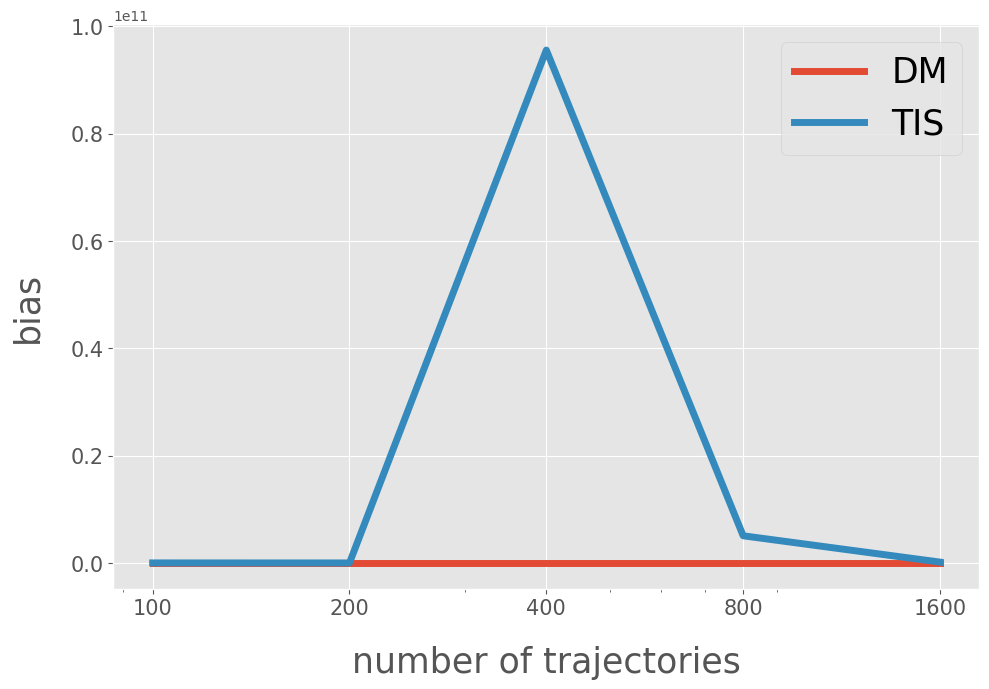

In [17]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 200, 400, 800, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_21380/132179728.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


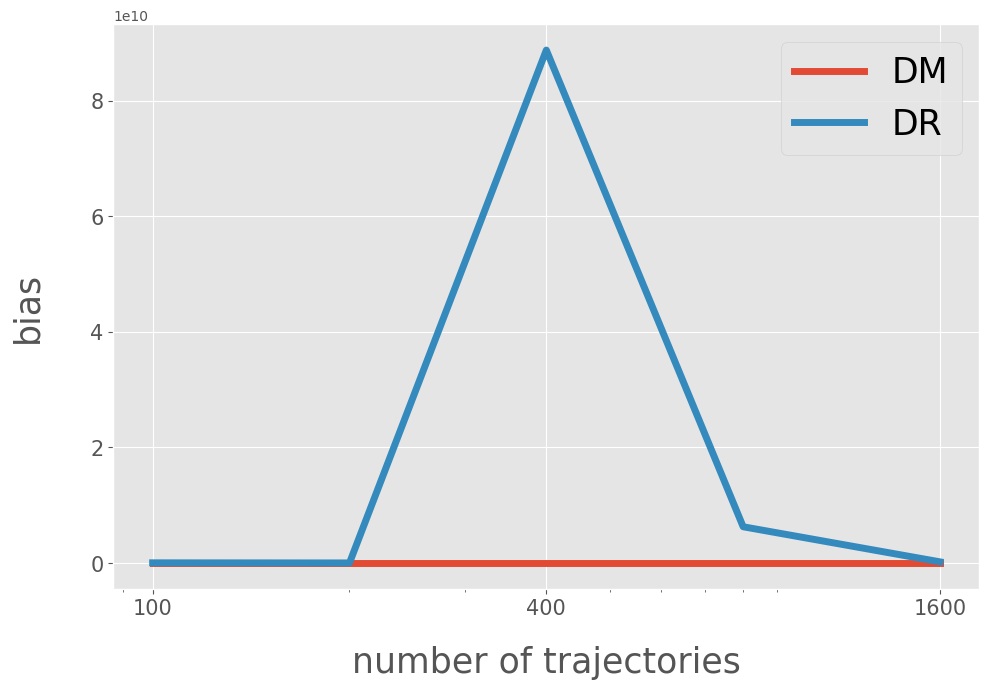

In [18]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(index == 'dm' or index == 'dr')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [19]:
variance_result_df

,index,level_1,variance,n_trajectories
0,on_policy,0,5.801566e-02,100
1,dm,0,1.018569e-02,100
2,tis,0,1.712657e+17,100
3,pdis,0,3.895584e+14,100
4,dr,0,3.448327e+15,100
...,...,...,...,...
80,sam_is,0,1.442039e-11,1600
81,sam_dr,0,1.085947e-02,1600
82,sam_snis,0,8.175082e+00,1600
83,sam_sndr,0,6.158723e+00,1600


/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_21380/1079444482.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


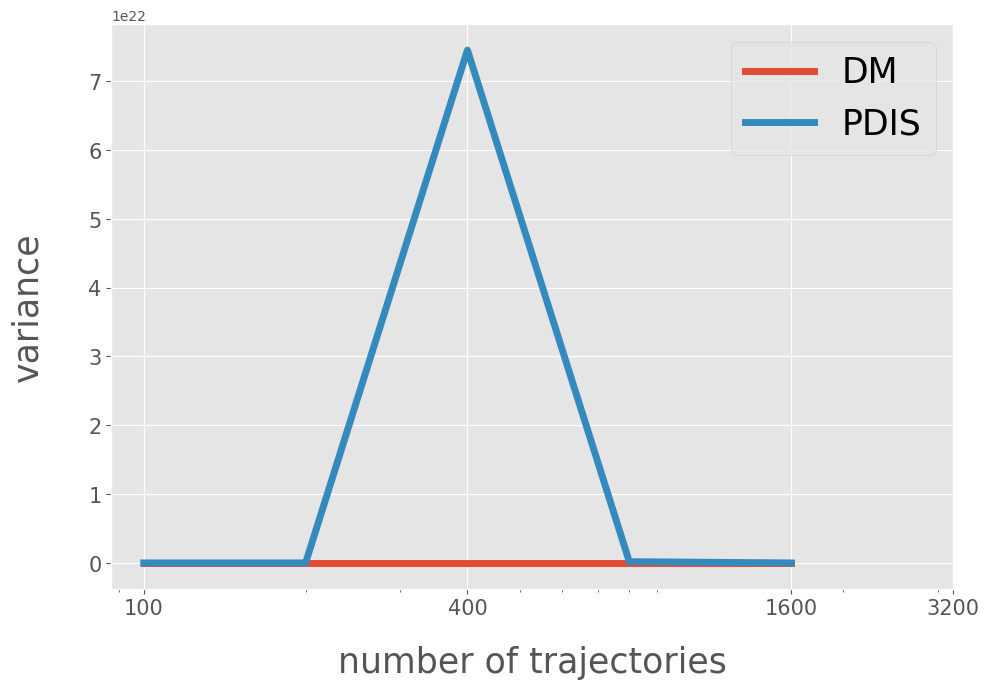

In [20]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 3200]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'dm' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "PDIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_21380/1525150744.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


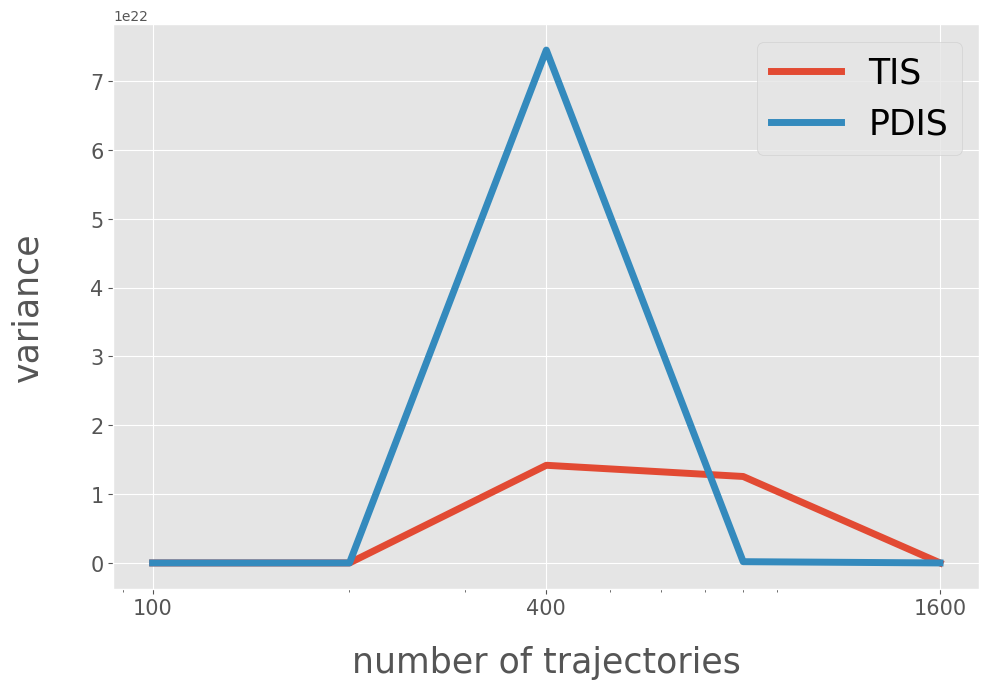

In [21]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'tis' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["TIS", "PDIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_21380/3324735909.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


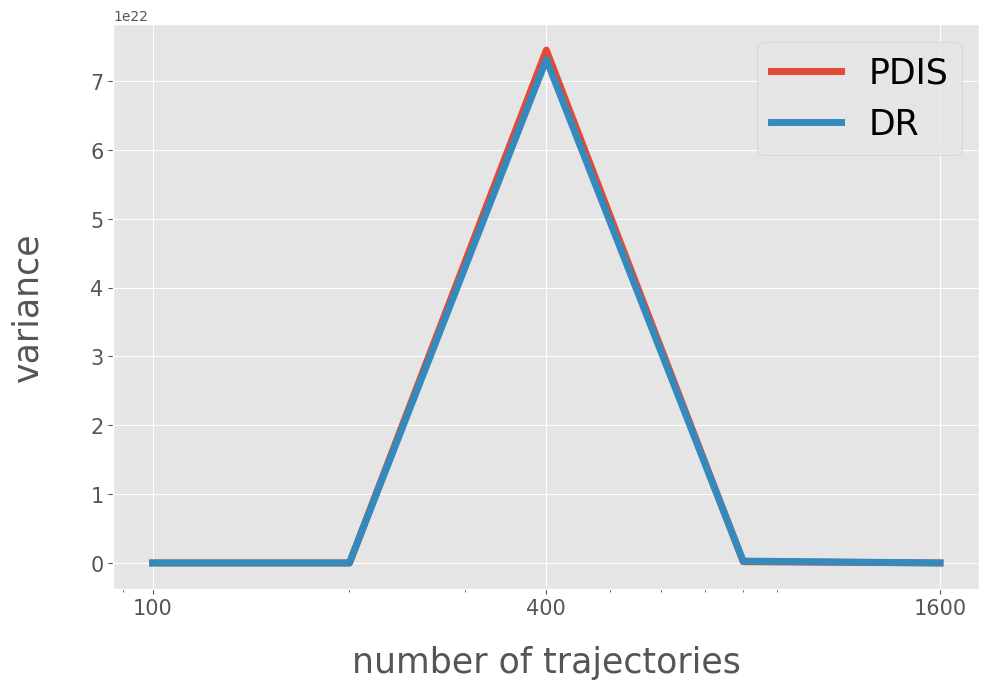

In [22]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'pdis' or index == 'dr')"),
    ci=None,
)
# title and legend
ax.legend(["PDIS", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)